In [1]:
%load_ext autoreload

%autoreload 2

from __future__ import print_function, division

import cPickle as pickle
from glob import glob
import subprocess
import sys
import string
import os
import random
import numpy as np
from os.path import join

import threebody

import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
logging.debug("test")

In [2]:
dmx_span = tuple(144.3+i*365.25 for i in range(6))
# old par file: 0337_de45.par
basic_params = dict(files="tuned2_aligned_pulses_1400_nosun2",
                     tzrmjd_middle='auto',
                     parfile="0337_de435_grpaper.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     efac=1,
                     t2_astrometry=True,
                     kopeikin=False,
                     ppn_mode='heavysimple',
                     linear_jumps=True,
                     linear_dm=False,
                     fdn_range=(1,5),
                     priors=('dbeta','dgamma'),
                     toa_mode="pipeline",
                     dmx_span=dmx_span,
                     variable_dm=True,
                     variable_ipm=True)


In [3]:
qsub_script = string.Template("""#!/bin/sh
#PBS -lnodes=1:ppn=1:compute:old
#PBS -N threebody_downhill_$name
#PBS -V
#PBS -o $DIR/pbs.out
#PBS -e $DIR/pbs.err

cd $here
export PATH=/users/aarchiba/.virtualenvs/triplesystem/bin:/users/aarchiba/.local/bin:/usr/local/src/presto/bin:/users/aarchiba/bin:/usr/local/src/fv5.4:/usr/local/openmpi-2.1.0/bin/:/users/aarchiba/.local/bin:/opt/rh/python27/root/usr/bin:/opt/rh/rh-git29/root/usr/bin:/opt/rh/devtoolset-6/root/usr/bin:/usr/local/src/presto/bin:/users/aarchiba/bin:/usr/local/src/fv5.4:/usr/local/openmpi-2.1.0/bin/:.:/users/aarchiba/bin:/opt/local/share/cv/bin:/usr/local/bin:/opt/local/bin:/bin:/usr/bin:/bin:/usr/etc:/usr/sbin:/sbin:/usr/local/sbin:/users/aarchiba/.local/bin:/opt/rh/python27/root/usr/bin:/opt/rh/rh-git29/root/usr/bin:/opt/rh/devtoolset-6/root/usr/bin:/usr/local/src/presto/bin:/usr/local/src/fv5.4:/usr/local/openmpi-2.1.0/bin/:/usr/lib64/qt-3.3/bin
export PYTHONPATH=

python downhill.py $DIR/fitter_params.pickle $DIR/best_values.pickle \
--method $method --best_parameters $sv > $DIR/stdout.txt
""")
def submit(params, name, method="BOBYQA", start=None):
    # FIXME: handle already-running jobs
    here = os.getcwd()
    DIR = join("downhill-runs",name)
    if not os.path.exists(DIR):
        os.makedirs(DIR)
    with open(join(DIR, "fitter_params.pickle"),"wb") as f:
        pickle.dump(params, f)
    F = threebody.Fitter(**params)
    if start is not None:
        F.best_parameters.update(start)
        sv = join(DIR, "start_values.pickle")
        with open(sv,"wb") as f:
            pickle.dump(F.best_parameters, f)
    else:
        sv = "default"
    for p in F.parameters:
        if p not in F.best_parameters:
            raise ValueError("best parameters don't include %s" % p)
    print("Initial goodness of fit:", F.goodness_of_fit(),
          "/", len(F.mjds))
    #if F.goodness_of_fit()>1e6:
    #    raise ValueError
    s = qsub_script.substitute(**locals())
    P = subprocess.Popen(["qsub","-"],stdin=subprocess.PIPE,
                         stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE)
    out, err = P.communicate(input=s)
    if P.returncode:
        raise ValueError("qsub returned %s, output:\n%s\nerror:\n%s"
                         % (P.returncode, out, err))
    return out, err

In [4]:
start=None

In [5]:
jobid = "12710"
job_dir = glob(os.path.join("emcee-chains",jobid+".*"))[0]

with open(os.path.join(job_dir,"fitter_params.pickle")) as f:
    fitter_params = pickle.load(f)

F = threebody.Fitter(**fitter_params)
best_so_far = np.load(os.path.join(job_dir,"best_so_far.npy"))
start = F.best_parameters.copy()
for i,p in enumerate(F.parameters):
    start[p] = best_so_far[i]
G = threebody.Fitter(**basic_params)
print("MCMC setup before:", F.goodness_of_fit(), 
      "after:", F.goodness_of_fit(start))
print("basic_params before:", G.goodness_of_fit(),
      "after:", G.goodness_of_fit(start))

/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/optimize/zeros.py:173: RuntimeWarning: Tolerance of -2.16840434497e-19 reached
  warnings.warn(msg, RuntimeWarning)


MCMC setup before: 36705.6440017 after: 36706.3737104
basic_params before: 36705.6440017 after: 36706.3737104


In [6]:
submit(fitter_params, "MCMC", start=start)

Initial goodness of fit: 36706.3737104 / 27110


('13351.nimrod.cv.nrao.edu\n', '')

In [411]:
p = basic_params.copy()
submit(p,"heavysimple",start=start)
#submit(p,"heavysimple",method="basinhopping",start=start)


Initial goodness of fit: 36706.9372785 / 27110


('5550.nimrod.cv.nrao.edu\n', '')

In [412]:
p = basic_params.copy()
p["files"] = "tuned2_aligned_pulses_1400_nosun2"
submit(p,"lband",start=start)


Initial goodness of fit: 36706.9372785 / 27110


('5551.nimrod.cv.nrao.edu\n', '')

In [394]:
p = basic_params.copy()
p["ppn_mode"] = "GR"
p["dmx_span"] = 1
p["variable_ipm"] = False
submit(p,"GRdaily")
#submit(p,"GR",start=start)
#submit(p,"GR",method="Powell",start=start)
#submit(p,"GR",method="basinhopping",start=start)


Initial goodness of fit: 34189.8614823 / 27110


('4817.nimrod.cv.nrao.edu\n', '')

In [301]:
p = basic_params.copy()
#p["files"] = "tuned2_aligned_pulses_1400_nosun2"
p["linear_dm"] = True
p["variable_dm"] = False
p["variable_ipm"] = False
submit(p,"dmtesting",start=start)
#submit(p,"heavysimple",method="basinhopping",start=start)
p

Initial goodness of fit: 40509.078393 / 27138


{'dmx_span': (144.3, 509.55, 874.8, 1240.05, 1605.3, 1970.55),
 'efac': 1,
 'fdn_range': (1, 5),
 'files': 'tuned2_aligned_pulses_1400_nosun2',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'kopeikin': False,
 'linear_dm': True,
 'linear_jumps': True,
 'parfile': '0337_de435.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'toa_mode': 'pipeline',
 'tzrmjd_middle': 'auto',
 'variable_dm': False,
 'variable_ipm': False}

In [7]:
p = basic_params.copy()
p["shapiro"] = False
submit(p,"noshapiro")
#submit(p,"GR",start=start)
#submit(p,"GR",method="Powell",start=start)
#submit(p,"GR",method="basinhopping",start=start)


Initial goodness of fit: 112929.438844 / 27110


('13434.nimrod.cv.nrao.edu\n', '')

In [16]:
fpickle = "forecaster_params.pickle"
p = pickle.load(open(fpickle,"rb"))
p["ppn_mode"] = "heavysimple"
p["toa_mode"] = "pipeline"
p["files"] = "fake_short"
submit(p,"fake")


Initial goodness of fit: 666.562909427 / 39980


('13514.nimrod.cv.nrao.edu\n', '')

In [21]:
fpickle = "forecaster_params.pickle"
p = pickle.load(open(fpickle,"rb"))
p["special"] = False
p["ppn_mode"] = "heavysimple"
p["toa_mode"] = "pipeline"
p["files"] = "fake_noSR"
submit(p,"fake_noSR")


Initial goodness of fit: 0.000368325848273 / 39980


('13532.nimrod.cv.nrao.edu\n', '')

In [27]:
fpickle = "forecaster_params.pickle"
p = pickle.load(open(fpickle,"rb"))
p["special"] = False
p["general"] = False
p["ppn_mode"] = "heavysimple"
p["toa_mode"] = "pipeline"
p["files"] = "fake_noSR_noGR"
submit(p,"fake_noSR_noGR")


Initial goodness of fit: 0.000367348315859 / 39980


('13551.nimrod.cv.nrao.edu\n', '')

In [26]:
fpickle = "forecaster_params.pickle"
p = pickle.load(open(fpickle,"rb"))
p["special"] = False
p["ppn_mode"] = "heavysimple"
p["toa_mode"] = "pipeline"
p["files"] = "fake_short"
submit(p,"SReffects")


Initial goodness of fit: 289626175.675 / 39980


('13550.nimrod.cv.nrao.edu\n', '')

In [34]:
fpickle = "forecaster_params.pickle"
p = pickle.load(open(fpickle,"rb"))
p["ppn_mode"] = "heavysimple"
p["toa_mode"] = "pipeline"
p["files"] = "fake_delta"
submit(p,"nonzerodelta")

Initial goodness of fit: 0.000369896557783 / 39980


('13572.nimrod.cv.nrao.edu\n', '')

In [44]:
fpickle = "forecaster_params.pickle"
p = pickle.load(open(fpickle,"rb"))
p["ppn_mode"] = "GR"
p["toa_mode"] = "pipeline"
p["files"] = "fake_delta"
submit(p,"nonzerodelta_nonlinear", method="Powell")

Initial goodness of fit: 5678239.4674 / 39980


('13610.nimrod.cv.nrao.edu\n', '')

In [29]:
fpickle = "forecaster_params.pickle"
p = pickle.load(open(fpickle,"rb"))
p["special"] = False
p["general"] = False
p["ppn_mode"] = "heavysimple"
p["toa_mode"] = "pipeline"
p["files"] = "fake_short"
submit(p,"SRGReffects")


Initial goodness of fit: 8444341363.56 / 39980


('13569.nimrod.cv.nrao.edu\n', '')

## Paper runs

In [31]:
p = basic_params.copy()
submit(p,"primary",start=start)

Initial goodness of fit: 36705.6043777 / 27110


('13570.nimrod.cv.nrao.edu\n', '')

In [28]:
p = basic_params.copy()
p["files"] = "tuned2_aligned_pulses_5deg"
submit(p,"lowfreq",start=start)

Initial goodness of fit: 43212.6245116 / 27193


('12701.nimrod.cv.nrao.edu\n', '')

In [29]:
p = basic_params.copy()
p["ppn_mode"] = "newtondelta"
submit(p,"newton",start=start)

Initial goodness of fit: 88927.6731992 / 27110


('12702.nimrod.cv.nrao.edu\n', '')

In [30]:
p = basic_params.copy()
p["ppn_mode"] = "GR"
submit(p,"GR")
#submit(p,"GR",start=start)
#submit(p,"GR",method="Powell",start=start)
#submit(p,"GR",method="basinhopping",start=start)


Initial goodness of fit: 36950.4901041 / 27110


('12703.nimrod.cv.nrao.edu\n', '')

In [32]:
p = basic_params.copy()
p["dmx_span"] = 1
p["variable_ipm"] = False
submit(p,"dailyDM",start=start)

Initial goodness of fit: 34185.5344808 / 27110


('13571.nimrod.cv.nrao.edu\n', '')

In [32]:
p = basic_params.copy()
p["files"] = "tuned2_aligned_pulses_5deg_WSRT"
submit(p,"WSRT",start=start)
#submit(p,"WSRT",method="Powell",start=start)
#submit(p,"WSRT",method="basinhopping",start=start)


Initial goodness of fit: 4077.81736378 / 3268


('12705.nimrod.cv.nrao.edu\n', '')

In [33]:
p = basic_params.copy()
p["files"] = "tuned2_aligned_pulses_5deg_AO"
submit(p,"AO",start=start)
#submit(p,"AO",method="Powell",start=start)
#submit(p,"AO",method="basinhopping",start=start)


Initial goodness of fit: 8990.97007473 / 5355


('12706.nimrod.cv.nrao.edu\n', '')

In [34]:
p = basic_params.copy()
p["files"] = "tuned2_aligned_pulses_5deg_GBT"
submit(p,"GBT",start=start)
#submit(p,"GBT",method="Powell")
#submit(p,"GBT",method="basinhopping")


Initial goodness of fit: 23244.9540406 / 18487


('12707.nimrod.cv.nrao.edu\n', '')

## Incorporate results into database

In [53]:
bpd = threebody.load_best_parameter_database()

for DIR in glob(join("downhill-runs","*")):
    name = DIR.split("/")[-1]
    d = pickle.load(open(join(DIR,"fitter_params.pickle")))
    F = threebody.Fitter(**d)
    try:
        p = pickle.load(open(join(DIR,"best_values.pickle")))
    except IOError:
        continue
    newp = F.best_parameters.copy()

    newp.update(p)
    if newp==F.best_parameters:
        print(name, "unchanged")
        continue
    try:
        old = F.goodness_of_fit(F.best_parameters)
    except KeyError:
        old = np.inf
    new = F.goodness_of_fit(newp)
    print(name, "existing best parameters:", old)
    print(name, "best parameters from fitter:", new)

    if new<old:
        bpd = threebody.load_best_parameter_database()
        print(name, "updating")
        bpd[F.bpd_k] = newp
        threebody.save_best_parameter_database(bpd)

WSRT unchanged
AO unchanged
GBT unchanged
heavysimple unchanged
GR unchanged
dmtesting unchanged
MCMC existing best parameters: 36705.5449482
MCMC best parameters from fitter: 36705.6043777
lband unchanged
primary unchanged
lowfreq unchanged
newton unchanged
dailyDM unchanged
GRdaily unchanged
noshapiro unchanged
fake existing best parameters: 0.000368325848273
fake best parameters from fitter: 917.206677001
SReffects unchanged
SRGReffects unchanged
nonzerodelta_nonlinear existing best parameters: 2019692.41541
nonzerodelta_nonlinear best parameters from fitter: 1879292.06362
nonzerodelta_nonlinear updating


1879292.06362


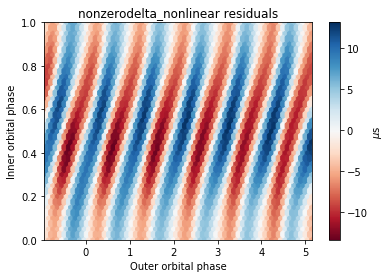

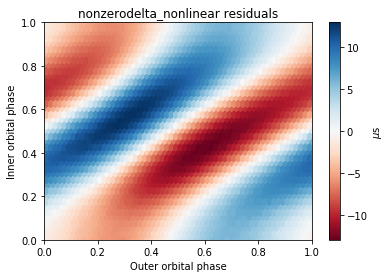

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
name = "nonzerodelta_nonlinear"
plt.set_cmap("RdBu")
F = threebody.Fitter(**pickle.load(open(join("downhill-runs",name,"fitter_params.pickle"))))
threebody.hexplot(F.best_parameters, F.mjds, 1e6*F.residuals()/F.reference_f0)
plt.colorbar().set_label(r"$\mu$s")
plt.title("%s residuals" % name)
print(F.goodness_of_fit())
plt.savefig("nonlinear_signature.pdf")
plt.figure()
threebody.hexplot(F.best_parameters, F.mjds, 1e6*F.residuals()/F.reference_f0, wrap_outer=True)
plt.colorbar().set_label(r"$\mu$s")
plt.title("%s residuals" % name)
plt.savefig("nonlinear_signature_one.pdf")
